In [1]:
import xarray as xr
import numpy as np
import random
import intake
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import BoundaryNorm
import seaborn as sn

from datetime import datetime

import geopy.distance
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.io.shapereader import Reader

In [2]:
def calculate_edges(field, threshold, lon_band):

    """
    Args:
        field (xarray.DataArray): A 2D array representing the field with latitude and longitude coordinates.
        threshold (float): The threshold value used to determine the edges.
        lon_band (tuple): A tuple specifying the longitude band of interest using (start, stop) values.

    Returns:
        float: The southernmost latitude where the field exceeds the threshold.
        float: The first latitude north of the southern_edge where the field drops below the threshold.
    """

    latitude_values = field.latitude.values
    mean_field = field.sel(longitude=slice(*lon_bands[lon_band])).mean(dim='longitude')
    
    if (np.sum((mean_field>threshold).values) > 2) & (np.sum((mean_field>threshold).values)<len(mean_field)): 
    
        southern_edge = mean_field.latitude.where(mean_field > threshold).min(dim='latitude', skipna=True).compute().values
        field_north_of_south_edge = mean_field.sel(latitude = slice(mean_field.latitude.max(), southern_edge))
        northren_edge = field_north_of_south_edge.latitude.where(field_north_of_south_edge < threshold).min(dim='latitude', skipna=True).compute().values

    else:
        print("No latitude where the field exceeds threshold found.")
        southern_edge, northren_edge = np.nan, np.nan

    return southern_edge, northren_edge

def calc_circle_center_coordinates(field, threshold, lon_band):
    
    # Calculates circle center coordinates based on the edges 
    
    lon_edge1 = np.mean(lon_bands[lon_band])
    lat_edge1_south, lat_edge1_north = calculate_edges(field, threshold, lon_band)
    
    if (np.isnan(lat_edge1_south) or np.isnan(lat_edge1_north)):
        return [(np.nan, np.nan)]
    
    else:
        circle_coords = [(lat_edge1_north, lon_edge1), ((lat_edge1_north+lat_edge1_south)*0.5, lon_edge1) , (lat_edge1_south, lon_edge1)]
        return circle_coords
    
def calc_leg_coordinates(lon_band, circle_coords, circle_rad_deg):
    
    # Calculates straight legs connecting the circles and the airport
    
    if lon_band == 'east':
        lat_airport, lon_airpot = coordinates['salNorth'], coordinates['salEast']  

    elif lon_band == 'west':
        lat_airport, lon_airpot = coordinates['bcoNorth'], coordinates['bcoEast'] 

    else:
        lat_airport, lon_airpot = np.nan, np.nan
        
    leg_coords = [(lat_airport, lon_airpot)]
    
    [(c_lat_north, c_lon), (_, _), (c_lat_south, _)] = circle_coords
    
    leg_coords.append((c_lat_north + circle_rad_deg, c_lon))
    leg_coords.append((c_lat_south - circle_rad_deg, c_lon))
        
    return leg_coords

In [3]:
(16+59/60.0)/60

0.28305555555555556

In [4]:
cat = intake.open_catalog('https://tcodata.mpimet.mpg.de/internal.yaml')
ds = cat.ORCESTRA.orcestra_preparations_era5.to_dask()

In [5]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 
               'salNorth': 16.74, 'salEast': -22.94, 
               'bcoNorth': 13.15, 'bcoEast': -59.42,
               'opNorth':48.08, 'opEast': 11.28 #48° 4′ 53″ N, 11° 16′ 59″ O.
              } 

lon_bands = {'entire': [-50, -20], 'west': [-48, -46], 'east': [-24, -22]}

In [6]:
# Flight track

circle_rad_deg = 1.0
circle_duration_h = 1.5

halo_speed_km_h = 850

threshold = 45.0
    
def calc_flight_track(field, lon_band, threshold = threshold):
    
    # Calculates circle center coordinates based on the edges 
    
    circle_coords = calc_circle_center_coordinates(field, threshold, lon_band)
    
    if np.isnan(circle_coords).any():
        return None
    
    
    leg_coords = calc_leg_coordinates(lon_band, circle_coords, circle_rad_deg)


    try:
        distanceKm = 0
        for i_coord in range(len(leg_coords)-1):
            distanceKm += geopy.distance.geodesic(leg_coords[i_coord], leg_coords[i_coord+1]).km
        distanceKm = distanceKm*2 # need to get back as well :-)

    except:
        print(leg_coords)
        distanceKm = np.nan
        
    duration = circle_duration_h*len(circle_coords) + distanceKm/halo_speed_km_h 
    
    return circle_coords, leg_coords, distanceKm, duration

In [7]:
# Style flight track
color_tr= '#005652'#'k'
linestyle_tr = 'solid'

In [8]:
# Load the dictionary from the JSON file
with open('track.json', 'r') as json_file:
    track_dic = json.load(json_file)


HALO (ERA5 Total column vertically-integrated water vapour 2001-08-15 12:00:00)
east
Lenght of straight legs: 2763km
Roughly estimated duration 7h
west
Lenght of straight legs: 5844km
Roughly estimated duration 11h


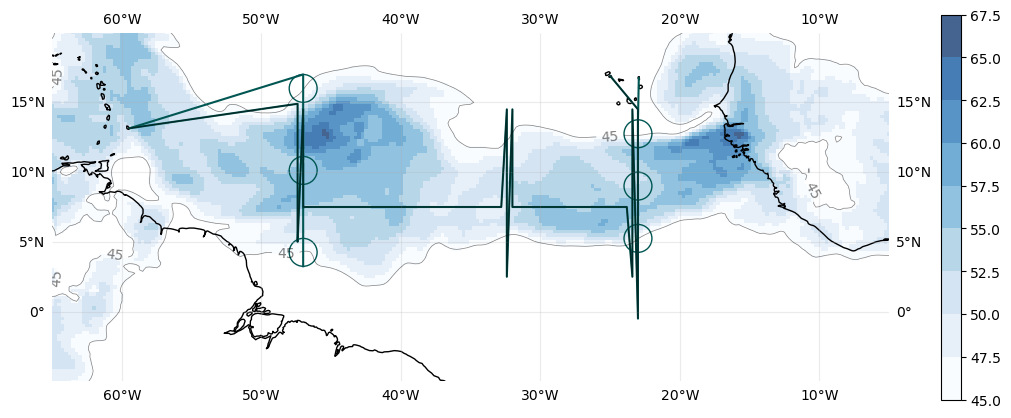

In [13]:
cmap = plt.colormaps['Blues']

threshold = 45

levels_cwv = [threshold]

norm = BoundaryNorm(np.arange(threshold, 70, 2.5), ncolors=cmap.N, clip=True)

plt.figure(figsize = (13.5, 5.0))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

ax.set_xlim(ds.longitude.min().values, -5)
ax.set_ylim(-5, 20)

plt.box(on=None)

#Add the shapefiles
direc_shp, file_shp = './EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)
#ax.add_feature(shape_feature,zorder=1)

p1 = plt.plot(track_dic['track_lon'], track_dic['track_lat'], color=color_tr, linestyle = linestyle_tr)
plt.savefig(f"./sample_tracks_{time.year}_{time.month}_{time.day}_empty.pdf");

time = datetime(2001, 8, 15, 12, 0, 0)
#time = random.choice(ds.time).values

field = ds.sel(time = time, method = 'nearest').tcwv
#field = ds.mean('time').tcwv

field_masked = np.ma.masked_where(field.values < threshold, field.values)

plt.pcolormesh(field.longitude.values, 
               field.latitude.values,
               field_masked,
               alpha = 0.75,
               shading='nearest', 
               cmap = cmap,
               norm=norm
              )
plt.colorbar()

contour_lines = plt.contour(field.longitude.values, 
                            field.latitude.values,
                            field.values,  # Change this to your data
                            levels=levels_cwv,  # Contour levels
                            colors='k',  # Contour line color (black)
                            linewidths=0.5,  # Contour line width
                            alpha = 0.5
                           )

# Add labels to the contour lines
plt.clabel(contour_lines, inline=True, fontsize=10, colors='k', fmt='%d')

print(f"HALO (ERA5 {field.long_name} {time})")

plt.savefig(f"./sample_tracks_{time.year}_{time.month}_{time.day}_cwv.pdf");

# Add flight track

for lon_band in ['east', 'west']:
    
    print(lon_band)

    circle_coords, coords_str, distanceKm, duration = calc_flight_track(field.sel(latitude = slice(25, 0)), lon_band, threshold)
    
    print(f'Lenght of straight legs: {int(distanceKm)}km')
    print(f'Roughly estimated duration {int(duration)}h')

    for circle_coord in circle_coords: 
        circle1 = Circle(circle_coord[::-1], circle_rad_deg, fill=False, color=color_tr, linestyle = linestyle_tr)
        ax.add_patch(circle1)

    flighLat, flightLon  = zip(*coords_str)
    plt.plot(flightLon, flighLat, color=color_tr, linestyle = linestyle_tr)

plt.savefig(f"./sample_tracks_{time.year}_{time.month}_{time.day}_plane.pdf");
    
# Plot ship track
p1 = plt.plot(track_dic['track_lon'], track_dic['track_lat'], alpha=0.5, color = 'k', linewidth = 1)



#plt.title(f"HALO (ERA5 {field.long_name} {time})")
plt.savefig(f"./sample_tracks_{time.year}_{time.month}_{time.day}.pdf");

In [10]:
plt.figure(figsize = (13.5, 5.0))

color_text = '#005555'

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#Add the shapefiles
direc_shp, file_shp = './EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)

plt.box(on=None)
sn.despine()

plt.scatter(coordinates['salEast'], coordinates['salNorth'], color = color_text, marker = 'x')
plt.scatter(coordinates['bcoEast'], coordinates['bcoNorth'], color = color_text, marker = 'x')
plt.scatter(coordinates['opEast'], coordinates['opNorth'], color = color_text, marker = 'x')

#plt.text(coordinates['salEast']+1.0, coordinates['salNorth'], "Cape Verde (SID)", horizontalalignment='left', size='medium', color='black')
ax.annotate("Cape Verde (SID) \n(08/2024 – 09/2024)", xy=(coordinates['salEast'], coordinates['salNorth']),
             xycoords='data',
             xytext=(coordinates['salEast']-15, coordinates['salNorth']+5),
             textcoords='data',
             color = color_text,
             arrowprops=dict(arrowstyle= '-|>',
                             color=color_text,
                             lw=1,
                             ls='-')
           )

plt.savefig('oneStage.pdf')


#plt.text(coordinates['bcoEast']+1.0, coordinates['bcoNorth'], "Barbados (BGI)", horizontalalignment='left', size='medium', color='black')
ax.annotate("Barbados (BGI) \n(09/2024)", xy=(coordinates['bcoEast'], coordinates['bcoNorth']),
             xycoords='data',
             xytext=(coordinates['bcoEast'], coordinates['salNorth']+5),
             textcoords='data',
             color = color_text,
             arrowprops=dict(arrowstyle= '-|>',
                             color=color_text,
                             lw=1,
                             ls='-')
           )

plt.savefig('twoStages.pdf')



ax.annotate("Germany (OBF) \n(11/2024)", xy=(coordinates['opEast'], coordinates['opNorth']),
             xycoords='data',
             xytext=(coordinates['opEast']-35, coordinates['opNorth']-2.5),
             textcoords='data',
             color = color_text,
             arrowprops=dict(arrowstyle= '-|>',
                             color=color_text,
                             lw=1,
                             ls='-')
           )


#ax.set_xlim(ds.longitude.min().values, 15)
#ax.set_ylim(-5, 50)

plt.savefig('threeStages.pdf')